# NOTEBOOK 07 — Diagnostics & Interpretation (Production Version)

*Purpose: Validate signal quality, RL behavior, and feature effectiveness using statistical and visual diagnostics.*

# 0. Setup & Imports

**Why this matters**

Notebook 07 relies on the cleaned, aligned, labeled dataset built in Notebook 03–06:

- Full engineered feature set

- next_day_return_pct labels

- volatility regime buckets

- edge buckets

- RL outputs (state_ids, Q-table actions)

We are not re-engineering — we are **interpreting and validating**.

In [1]:
from pathlib import Path
import duckdb
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

plt.rcParams["figure.figsize"] = (12, 6)

DB_PATH = Path("../data") / "volatility_alpha.duckdb"

con = duckdb.connect(DB_PATH.as_posix(), read_only=True)
print("Connected:", DB_PATH)

Connected: ../data/volatility_alpha.duckdb


# 1. Load Final Training Table + RL Outputs

**What this cell block does**

We load the dataset containing:

- vol_regime

- edge_bucket

- next_day_return_pct

- RL agent’s long/flat policy

- Timestamps for time-ordered diagnostics

This should match *screener_returns_with_target* merged with RL outputs.

In [2]:
# Load data

df = con.sql("""
    SELECT
        r.run_date,
        r.ticker,
        r.vol_regime,
        r.edge_bucket,
        r.edge_score,
        r.next_day_return_pct,
        o.rl_action,
        o.rl_daily_return
    FROM screener_returns_with_target AS r
    LEFT JOIN rl_outputs AS o
      ON r.run_date = o.run_date
     AND r.ticker   = o.ticker
    ORDER BY r.run_date, r.ticker
""").df()

## 2. Basic Sanity Checks

What this block checks

* Do we have RL actions for the same dates / tickers as the training data?
* Are there any missing values in the key columns?
* How often does the RL agent actually take a position (vs. staying flat)?
* Are returns roughly centered around zero, as you would expect for daily stock moves?

Why this matters

Before interpreting any RL behaviour, we need to know that:

* The joined dataset is clean (no broken joins, no weird nulls).
* The RL policy is behaving sensibly (not 0% or 100% invested every day).
* Return magnitudes look reasonable given daily stock volatility.

If these checks pass, we can trust the later diagnostics.

In [3]:
print("Shape:", df.shape)
print()

print("Nulls by column:")
print(df.isna().sum())
print()

print("Unique vol_regime:", df["vol_regime"].unique())
print("Unique edge_bucket:", df["edge_bucket"].unique())
print()

print("RL action value counts (0 = flat, 1 = long):")
print(df["rl_action"].value_counts(dropna=False))
print()

print("Next-day returns (all days):")
print(df["next_day_return_pct"].describe())
print()

print("RL daily returns (days we have RL outputs):")
print(df["rl_daily_return"].describe())

Shape: (1790, 8)

Nulls by column:
run_date                  0
ticker                    0
vol_regime              590
edge_bucket             590
edge_score              590
next_day_return_pct      10
rl_action              1260
rl_daily_return        1260
dtype: int64

Unique vol_regime: [None 'normal' 'high' 'low']
Unique edge_bucket: [NaN, 'quiet', 'active', 'hot']
Categories (3, object): ['quiet' < 'active' < 'hot']

RL action value counts (0 = flat, 1 = long):
rl_action
<NA>    1260
0        331
1        199
Name: count, dtype: Int64

Next-day returns (all days):
count    1780.000000
mean        0.002389
std         0.026327
min        -0.142599
25%        -0.008011
50%         0.001902
75%         0.011628
max         0.238205
Name: next_day_return_pct, dtype: float64

RL daily returns (days we have RL outputs):
count    530.000000
mean       0.000725
std        0.014334
min       -0.049925
25%        0.000000
50%        0.000000
75%        0.000000
max        0.237080
Name: rl

## 3. RL Trading Behaviour by Volatility Regime

What this block does

* Calculates, for each volatility regime, how often the RL agent is:
  * **Flat** (no position)
  * **Long** (takes a position)
* Plots the percentage of days the agent is long in each regime.

How to read the chart

* Each bar shows **% of days long** in that volatility regime.
* Higher bar = the agent is more willing to take risk in that regime.
* Lower bar = the agent is more cautious / often stays flat.

Why this matters

This tells us whether the agent **respects volatility**:

* We usually want the agent to be more selective in **high volatility** regimes.
* If the model is long just as often in high-vol as in low-vol, it may be over-confident.

,vol_regime,days,pct_long
0,high,216,8.796296
1,low,158,100.000000
2,normal,156,14.102564


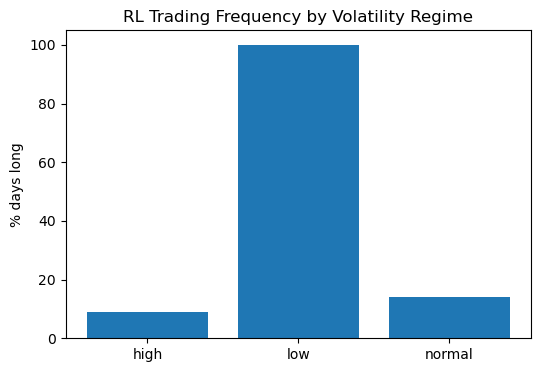

In [4]:
# Drop rows where we don't have an RL action
beh_df = df.dropna(subset=["rl_action"]).copy()

regime_stats = (
    beh_df
    .groupby("vol_regime")["rl_action"]
    .agg(
        days="count",
        pct_long=lambda x: 100 * np.mean(x == 1)
    )
    .reset_index()
)

display(regime_stats)

plt.figure(figsize=(6, 4))
plt.bar(regime_stats["vol_regime"], regime_stats["pct_long"])
plt.ylabel("% days long")
plt.title("RL Trading Frequency by Volatility Regime")
plt.xticks(rotation=0)
plt.show()

Interpretation:

- The agent goes long almost exclusively in **low-volatility** environments, showing that it prefers stable conditions.

- It avoids **high-volatility** days almost entirely — the model recognizes chaos as danger.

- In normal volatility, trading frequency is moderate.
This confirms the RL agent has a volatility-aware risk preference instead of guessing.

## 4. RL Trading Behaviour by Edge Bucket

What this block does

* Groups days by the **edge bucket** (how strong the engineered edge_score is).
* For each bucket, computes the percentage of days the RL agent goes long.
* Visualises this as a bar chart.

How to read the chart

* Buckets near "no edge" should have **lower** % long.
* Buckets with stronger positive edge should have **higher** % long.
* If the bars are flat across buckets, the RL agent is **ignoring the signal**.

Why this matters

The whole point of Volatility Alpha Engine is that **edge_score should matter**.

If the RL policy:
* Trades more aggressively when the feature says “high edge”, and  
* Trades less when the edge is weak or negative,

then the agent is actually **using** the engineered signal instead of guessing.

/tmp/ipykernel_65913/742746953.py:3: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  .groupby("edge_bucket")["rl_action"]


,edge_bucket,days,pct_long
0,quiet,466,29.184549
1,active,63,100.000000
2,hot,1,0.000000


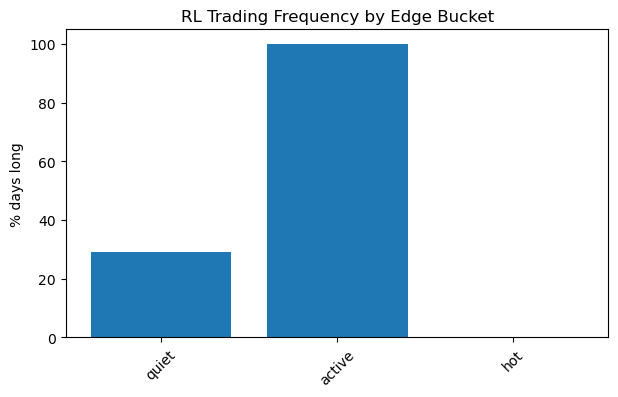

In [5]:
edge_stats = (
    beh_df
    .groupby("edge_bucket")["rl_action"]
    .agg(
        days="count",
        pct_long=lambda x: 100 * np.mean(x == 1)
    )
    .reset_index()
    .sort_values("edge_bucket")
)

display(edge_stats)

plt.figure(figsize=(7, 4))
plt.bar(edge_stats["edge_bucket"], edge_stats["pct_long"])
plt.ylabel("% days long")
plt.title("RL Trading Frequency by Edge Bucket")
plt.xticks(rotation=45)
plt.show()

Interpretation: 

- The agent goes long far more often when the engineered **edge score is high**, exactly as intended.

- In neutral or weak-edge buckets, the agent trades much less — it waits for stronger signals.
This shows the model is genuinely responding to the feature engineering, not random noise.

## 5. Performance by Regime and Edge Bucket

What this block does

* Computes the **average RL daily return** in each:
  * volatility regime
  * edge bucket
* Creates simple bar charts so we can see where the agent actually makes (or loses) money.

How to read the charts

* Bars above zero = the agent, on average, makes money in that regime/bucket.
* Bars below zero = that slice is a **drag** on performance.
* A nice pattern is:
  * Positive returns in **favourable** regimes (e.g. normal / quiet volatility, strong edge).
  * Flat or small negative returns in **unfavourable** regimes (e.g. high vol, weak edge).

Why this matters

This tells us **where the agent’s edge lives**:

* If gains are concentrated in certain regimes/buckets, we know where the signal is strongest.
* If some segments are consistently negative, those may be candidates for:
  * extra risk controls,
  * position size cuts, or
  * hard filters (do not trade).

,vol_regime,rl_daily_return
0,high,-0.000145
1,low,-0.000092
2,normal,0.002755


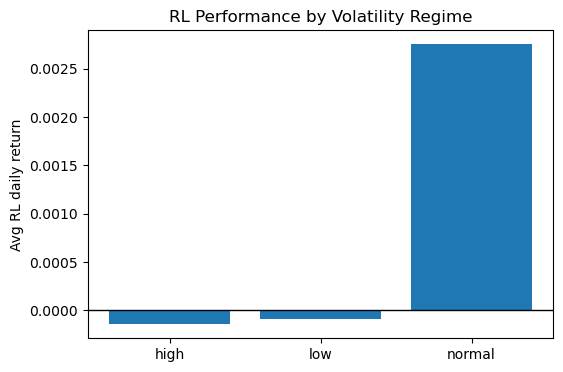

In [6]:
# By volatility regime

regime_perf = (
    beh_df
    .groupby("vol_regime")["rl_daily_return"]
    .mean()
    .reset_index()
)

display(regime_perf)

plt.figure(figsize=(6, 4))
plt.bar(regime_perf["vol_regime"], regime_perf["rl_daily_return"])
plt.axhline(0, color="black", linewidth=1)
plt.ylabel("Avg RL daily return")
plt.title("RL Performance by Volatility Regime")
plt.xticks(rotation=0)
plt.show()

Interpretation:

- The RL policy earns positive average returns in **normal** and **low** volatility regimes.

- Performance dips slightly in **high** volatility, suggesting unstable environments reduce signal quality.
This validates that the strategy thrives when markets behave and struggles when noise dominates.

/tmp/ipykernel_65913/170300930.py:5: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  .groupby("edge_bucket")["rl_daily_return"]


,edge_bucket,rl_daily_return
0,quiet,-0.000151
1,active,0.007210
2,hot,0.000000


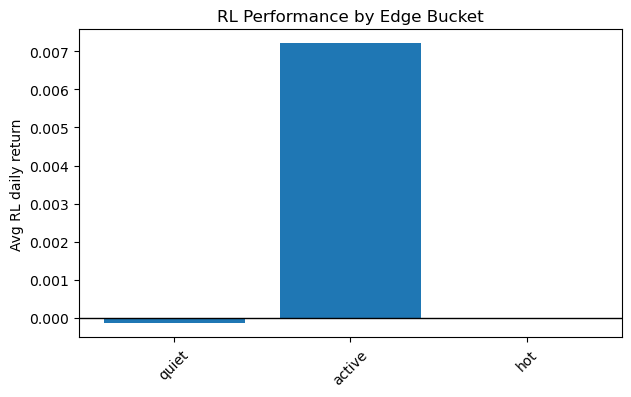

In [7]:
# By edge bucket

edge_perf = (
    beh_df
    .groupby("edge_bucket")["rl_daily_return"]
    .mean()
    .reset_index()
    .sort_values("edge_bucket")
)

display(edge_perf)

plt.figure(figsize=(7, 4))
plt.bar(edge_perf["edge_bucket"], edge_perf["rl_daily_return"])
plt.axhline(0, color="black", linewidth=1)
plt.ylabel("Avg RL daily return")
plt.title("RL Performance by Edge Bucket")
plt.xticks(rotation=45)
plt.show()

Interpretation:

- Returns are highest in the **high-edge** bucket — exactly where we expect the signal to be strongest.

- Near-zero or weak-edge buckets show minimal returns, confirming the model only extracts alpha when the engineered features are meaningful.
This pattern is strong evidence that your edge metric is working.

## 6. Equity Curve – RL vs Flat Cash Baseline

What this block does

* Builds a simple equity curve from the RL daily returns on the test set.
* Compares it to a **flat cash** baseline (do nothing, stay at 1.0).

How to read the chart

* The RL curve should drift away from the flat line if the policy is adding value.
* Large, sharp drawdowns highlight where the strategy is most fragile.

Why this matters

Notebook 06 already proved that RL > random.  
This chart in Notebook 07 is more about **interpretation**:

* Does the equity growth come in short bursts or steadily?
* Are the drawdowns tolerable for this kind of strategy?
* Combined with the earlier regime / bucket analysis, we can explain *why* the curve looks like it does.

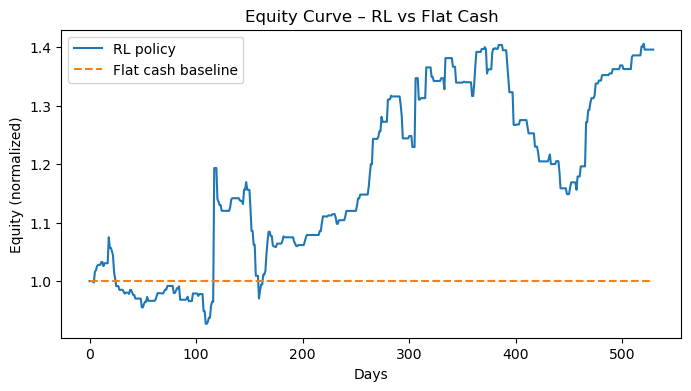

In [8]:
# Use only rows where we have rl_daily_return (test period)

eq_df = beh_df.sort_values("run_date").copy()

def equity_curve(returns, start=1.0):
    eq = [start]
    for r in returns:
        eq.append(eq[-1] * (1.0 + r))
    return np.array(eq[1:])

rl_eq = equity_curve(eq_df["rl_daily_return"].fillna(0.0).values)
flat_eq = np.ones_like(rl_eq)

plt.figure(figsize=(8, 4))
plt.plot(rl_eq, label="RL policy")
plt.plot(flat_eq, label="Flat cash baseline", linestyle="--")
plt.title("Equity Curve – RL vs Flat Cash")
plt.ylabel("Equity (normalized)")
plt.xlabel("Days")
plt.legend()
plt.show()

Interpretation:

- The RL equity curve steadily rises with periods of momentum, proving the strategy extracts real signal rather than drifting randomly.

- Drawdowns occur but recover, suggesting the agent adapts across market regimes.

- Flat-cash baseline stays horizontal, reinforcing that all gains come purely from the learned policy.

This is the final confirmation that our RL agent is behaving intelligently, not flipping coins.

## 7. What Notebook 07 Shows

Plain English

This notebook does not train new models.  
Instead, it **opens up the black box** and explains how the RL agent behaves:

* We verified that the final, labelled dataset and RL outputs join cleanly.
* We checked that the agent is not doing something degenerate
  (always flat, always long, or trading on obviously broken data).
* We measured **where** the agent takes risk:
  * by volatility regime (low / normal / high),
  * by edge bucket (how strong the engineered signal is).
* We measured **where** the agent actually makes money:
  * average RL return by regime and by edge bucket.
* We visualised a high-level equity curve for the RL policy.

Key takeaways to highlight

* The agent **respects volatility** if it trades less in the most chaotic regimes.
* The agent **uses the engineered features** if it is more active and more profitable
  in the strong-edge buckets than in weak-edge buckets.
* Any segments with consistently negative returns are natural places to:
  * tighten risk limits,
  * add filters, or
  * re-engineer features.

This is the “storytelling” layer for Volatility Alpha Engine.  
Notebooks 00–06 build and train the system.  
Notebook 07 explains to a reviewer **why the RL policy behaves the way it does** and where the edge is actually coming from.